# Pytorch-mini-LeNet-MNIST



Reference: https://xmfbit.github.io/2017/03/04/pytorch-mnist-example/

# What to learn in this notebook?
1. Import dataset and load it as batches
2. CNN model
3. Training, testing and save the model
4. Load model weights and predict
5. Visualize filter weights and feature maps in each layer
6. Save feature maps and input image

## 1. Import dataset and load it as batches

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
train_set = dset.MNIST(root='data/', train=True, transform=trans, download=True)
test_set = dset.MNIST(root='data/', train=False, transform=trans)
batch_size = 128
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

In [2]:
img_size = list(iter(train_loader))[0][0].shape
img_label = list(iter(train_loader))[0][1].shape
print(img_size) # batch_size, channel_size, h, w
print(img_label) # batch_size

torch.Size([128, 1, 28, 28])
torch.Size([128])


## 2. CNN model

In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1) # in_channel, out_channel, kernel, stride
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        '''
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        '''
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        '''
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        '''
        return x
    
    def name(self):
        return "LeNet"

In [4]:
# Check output size before FC layers

input_ = torch.rand([1, 1, 28, 28])

model = LeNet()
model(input_).shape # batch_size, out_channel, H, W

torch.Size([1, 50, 4, 4])

In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1) # in_channel, out_channel, kernel, stride
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        self.x1 = F.relu(self.conv1(x))
        self.x2 = F.max_pool2d(self.x1, 2, 2)
        self.x3 = F.relu(self.conv2(self.x2))
        self.x4 = F.max_pool2d(self.x3, 2, 2)
        self.x5 = self.x4.view(-1, 4*4*50)
        self.x6 = F.relu(self.fc1(self.x5))
        self.out = self.fc2(self.x6)
        return self.out
    
    def get_features(self):
        return self.x1, self.x2, self.x3, self.x4, self.x5, self.x6, self.out
        

## 3. Training, testing and save the model

In [6]:
import json

def state_dict2json(state_dict, PATH, return_checkpt = False):
    checkpoint_dict = {}

    for key in list(state_dict.keys()):
        checkpoint_dict[key] = state_dict[key].numpy().tolist()

    with open(PATH, 'w') as json_file:
        json.dump(checkpoint_dict, json_file)
    
    if return_checkpt:
        return checkpoint_dict


In [7]:
import time

## training
model = LeNet()

use_cuda = torch.cuda.is_available()

if use_cuda:
    print("CUDA")
    model = model.cuda()

# Define Loss and optimizer

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

train_acc_best = 0.
for epoch in range(3):
    ## training
    correct_cnt, train_loss = 0, 0
    total_cnt = 0
    
    START = time.time()
    for batch_idx, (x, target) in enumerate(train_loader):
        
        # Input
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        # x, target = Variable(x), Variable(target)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        
        # Predict
        out = model(x)
        
        # Size
        sample_size = x.data.size()[0]
        total_cnt += sample_size
        
        # Loss
        loss = criterion(out, target)
        train_loss = (train_loss * (total_cnt - sample_size) + loss.item()) / total_cnt # avg_loss = avg_loss * 0.9 + loss.data[0] * 0.1
        
        # Accuracy
        _, pred_label = torch.max(out, 1)
        correct_cnt += (pred_label == target.data).sum().item()
        train_acc = correct_cnt * 1.0 / total_cnt
        
        # Update gradients
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(train_loader):
            END = time.time()
            print('Epoch: {}, Batch: {}/{}, Time: {:.4f}, Train loss: {:e}, Train accuracy: {:.6f}'.format(
                epoch, batch_idx + 1,  len(train_loader), END - START, train_loss, train_acc))
            START = time.time()
    
    # Save the better models
    if train_acc > train_acc_best:
        train_acc_best = train_acc
        torch.save(model.state_dict(), 'weights/LeNet_epoch{}'.format(epoch))
        
        PATH = 'weights/LeNet_epoch{}.json'.format(epoch)
        state_dict = model.state_dict()
        state_dict2json(state_dict, PATH, return_checkpt = False)
        
        print('Weights in Epoch {} saved.'.format(epoch))
    
    ## testing
    
    correct_cnt, test_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        # Input
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        # x, target = Variable(x, volatile = True), Variable(target, volatile = True)
        
        # Predict
        out = model(x)
        
        # Size
        sample_size = x.data.size()[0]
        total_cnt += sample_size
        
        # Loss
        loss = criterion(out, target)
        # (smooth average)
        test_loss = (test_loss * (total_cnt - sample_size) + loss.item()) / total_cnt
    
        # Accuracy
        _, pred_label = torch.max(out.data, 1)
        correct_cnt += (pred_label == target.data).sum().item()
        test_acc = correct_cnt * 1.0 / total_cnt
        
        '''
        if(batch_idx + 1) % 100 == 0 or (batch_idx + 1) == len(test_loader):
            print('Epoch: {}, Batch: {}/{}, Test loss: {:e}, Test accuracy: {:.6f}'.format(
                epoch, batch_idx + 1, len(train_loader), test_loss, test_acc))
        '''
    print('=======>  Train loss: {:e}, Train accuracy: {:.6f}, Test loss: {:e}, Test accuracy: {:.6f}\n'.format(
        train_loss, train_acc, test_loss, test_acc))

# torch.save(model.state_dict(), model.name())

Epoch: 0, Batch: 100/469, Time: 22.8081, Train loss: 1.317313e-02, Train accuracy: 0.566641
Epoch: 0, Batch: 200/469, Time: 22.1634, Train loss: 7.928229e-03, Train accuracy: 0.731367
Epoch: 0, Batch: 300/469, Time: 23.3106, Train loss: 5.814007e-03, Train accuracy: 0.800339
Epoch: 0, Batch: 400/469, Time: 24.3697, Train loss: 4.650422e-03, Train accuracy: 0.838945
Epoch: 0, Batch: 469/469, Time: 17.1207, Train loss: 4.116059e-03, Train accuracy: 0.856733
Weights in Epoch 0 saved.
=======>  Train loss: 4.116059e-03, Train accuracy: 0.856733, Test loss: 7.626649e-04, Test accuracy: 0.970700

Epoch: 1, Batch: 100/469, Time: 21.5899, Train loss: 8.859608e-04, Train accuracy: 0.966406
Epoch: 1, Batch: 200/469, Time: 23.9347, Train loss: 8.033895e-04, Train accuracy: 0.968672
Epoch: 1, Batch: 300/469, Time: 22.2614, Train loss: 7.650028e-04, Train accuracy: 0.970365
Epoch: 1, Batch: 400/469, Time: 24.1283, Train loss: 7.260333e-04, Train accuracy: 0.971191
Epoch: 1, Batch: 469/469, Time: 16

## 4. Load model weights and predict

In [8]:
# Load model and weights
model = LeNet()
model.load_state_dict(torch.load('weights/LeNet_epoch2'))
model.eval()
model.parameters()

<generator object Module.parameters at 0x7f4d640fdb10>

In [9]:
# Predict an image
## 
images, gts = list(iter(test_loader))[0]
img = images[0]
gt = gts[0]
print(img.shape, gt)

## plot
import matplotlib.pyplot as plt

plt.imshow(img.squeeze(0).numpy(), cmap = 'Greys')

## predict
pred_result = model(img.unsqueeze(0)).argmax()
print(pred_result)

torch.Size([1, 28, 28]) tensor(7)
tensor(7)


In [10]:
# list(model.parameters())

## 5. Visualize filter weights and feature maps in each layer

torch.Size([1, 5, 5]) torch.Size([5, 5])
torch.Size([1, 5, 5]) torch.Size([5, 5])
torch.Size([1, 5, 5]) torch.Size([5, 5])
torch.Size([1, 5, 5]) torch.Size([5, 5])
torch.Size([1, 5, 5]) torch.Size([5, 5])
torch.Size([20, 1, 5, 5])


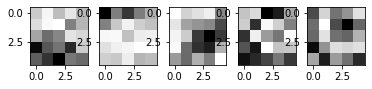

In [11]:
# Visualize conv1 filter
kernels = model.conv1.weight.detach()
plt.figure()
for idx in range(kernels.size(0))[:5]:
    plt.subplot(151 + idx)
    plt.imshow(kernels[idx].squeeze(), cmap = 'Greys')
    print(kernels[idx].shape, kernels[idx].squeeze().shape)
print(kernels.size())

In [12]:
model.conv2.weight.detach().size()

torch.Size([50, 20, 5, 5])

torch.Size([5, 5]) torch.Size([5, 5])
torch.Size([5, 5]) torch.Size([5, 5])
torch.Size([5, 5]) torch.Size([5, 5])
torch.Size([5, 5]) torch.Size([5, 5])
torch.Size([5, 5]) torch.Size([5, 5])
torch.Size([5, 5]) torch.Size([5, 5])
torch.Size([5, 5]) torch.Size([5, 5])
torch.Size([5, 5]) torch.Size([5, 5])
torch.Size([50, 20, 5, 5])


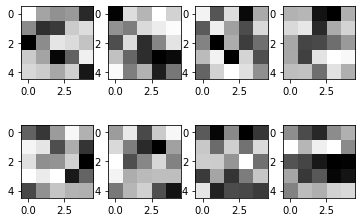

In [13]:
# Visualize conv2 filter
kernels = model.conv2.weight.detach()
plt.figure()
count = 0
for idx0 in range(kernels.size(0))[:4]:
    for idx1 in range(kernels.size(1))[:2]:
        plt.subplot(241 + count)
        count += 1
        plt.imshow(kernels[idx0][idx1].squeeze(), cmap = 'Greys')
        print(kernels[idx0][idx1].shape, kernels[idx0][idx1].squeeze().shape)
print(kernels.size())

In [14]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [15]:
model.eval()

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [16]:
# for name, param in model.state_dict().items():
#     print(name, param)

In [17]:
# Feature maps
fmaps = model.get_features()
len(fmaps)

7

In [18]:
## Size
[fmap.shape for fmap in fmaps]

[torch.Size([1, 20, 24, 24]),
 torch.Size([1, 20, 12, 12]),
 torch.Size([1, 50, 8, 8]),
 torch.Size([1, 50, 4, 4]),
 torch.Size([1, 800]),
 torch.Size([1, 500]),
 torch.Size([1, 10])]

In [19]:
## Visualize fmap - relu(conv1)
fmap0 = fmaps[0]
fmap0.squeeze().size(0)

20

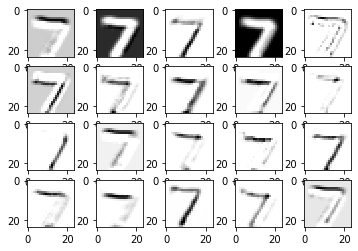

In [20]:
plt.figure()

for i in range(fmap0.squeeze().size(0)):
    plt.subplot(4, 5, i + 1)
    plt.imshow(fmap0.squeeze()[i].detach().numpy(), cmap = 'Greys')

In [21]:
## Visualize fmap - max_pool1
fmap1 = fmaps[1]
fmap1.squeeze().size(0)

20

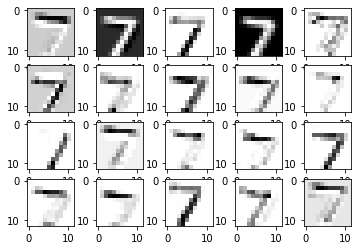

In [22]:
plt.figure()

for i in range(fmap1.squeeze().size(0)):
    plt.subplot(4, 5, i + 1)
    plt.imshow(fmap1.squeeze()[i].detach().numpy(), cmap = 'Greys')


In [23]:
## Visualize fmap - relu(conv2)
fmap2 = fmaps[2]
fmap2.squeeze().size(0)

50

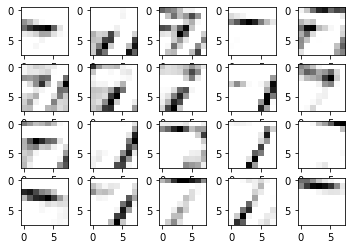

In [24]:
plt.figure()

for i in range(fmap2.squeeze().size(0))[:20]: # sample 20 from 50 chnnels
    plt.subplot(4, 5, i + 1)
    plt.imshow(fmap2.squeeze()[i].detach().numpy(), cmap = 'Greys')

In [25]:
## Visualize fmap - max_pool2
fmap3 = fmaps[3]
fmap3.squeeze().size(0)

50

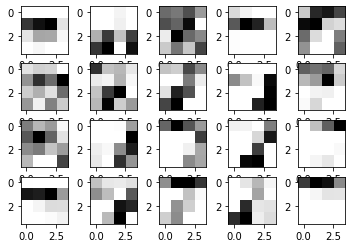

In [26]:
plt.figure()

for i in range(fmap3.squeeze().size(0))[:20]: # sample 20 from 50 chnnels
    plt.subplot(4, 5, i + 1)
    plt.imshow(fmap3.squeeze()[i].detach().numpy(), cmap = 'Greys')


## 6. Save feature maps and input image

In [27]:
# Save fmaps as .json
fmaps_dict = {}
for i in range(len(fmaps)):
    fmaps_dict['fmap{}'.format(i)] = fmaps[i].detach().numpy().tolist()

with open('fmaps/fmaps.json', 'w') as json_file:
    json.dump(fmaps_dict, json_file)
    

In [28]:
# Load saved .json 
with open('fmaps/fmaps.json', 'r') as json_file:
    tmp = json.load(json_file)

tmp.keys()

dict_keys(['fmap0', 'fmap1', 'fmap2', 'fmap3', 'fmap4', 'fmap5', 'fmap6'])

In [29]:
# Save fmaps saparately
for i in range(len(fmaps)):
    with open('fmaps/fmap_flatten{}.txt'.format(i), 'w') as f:
        pixels = fmaps[i].view(-1).detach().numpy().tolist()
        for px in pixels:
            f.write('{}\n'.format(px))

In [30]:
# Check file 'fmaps/fmap_flatten0.txt'
with open('fmaps/fmap_flatten0.txt', 'r') as f:
    data = f.read().splitlines()
    
data = [float(i) for i in data]
# data

In [31]:
# Save the testing input img as well


In [32]:
with open('input/input_img.txt', 'w') as f:
    pixels = img.view(-1).numpy().tolist()
    for px in pixels:
        f.write('{}\n'.format(px))

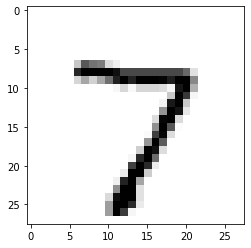

In [33]:
# Check file 'input/input_img.txt'
with open('input/input_img.txt', 'r') as f:
    data = f.read().splitlines()
    
data = [float(i) for i in data]


import numpy as np 

data = np.array(data).reshape([28, 28])

plt.imshow(data, cmap = 'Greys')